=== OFDM over Known Multipath Channel ===
Number of subcarriers       = 64
QAM order                   = 16 (bits/symbol=4)
Number of OFDM symbols      = 5
Cyclic Prefix length        = 5
Channel impulse response h  = [1.  +0.j  0.3 +0.1j 0.05+0.j ]
SNR (dB)                    = 15
Total bits transmitted      = 1280
Bit errors                  = 21
BER                         = 1.640625e-02


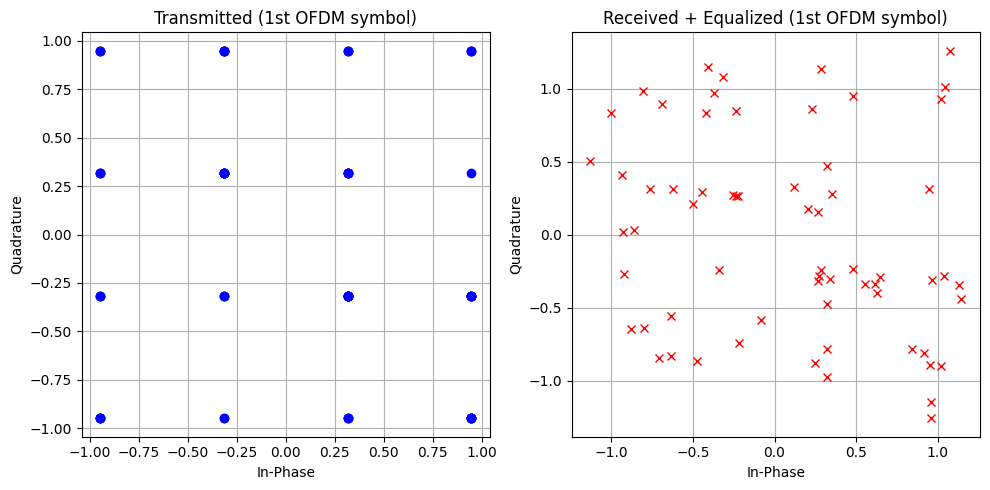

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1. SYSTEM & SIMULATION PARAMETERS
# -----------------------------------------------------------

N_subcarriers   = 64        # Number of OFDM subcarriers (FFT size)
QAM_order       = 16         # QAM constellation order (4=QPSK, 16=16QAM, etc.) - bits each subcarrier carries
N_OFDM_symbols  = 5         # How many OFDM symbols to send
CP_len          = 5        # Cyclic Prefix length (samples)
snr_dB          = 15        # SNR in dB for AWGN channel

# Define a multipath channel impulse response (length <= CP_len ideally)
h = np.array([1, 0.3 + 0.1j, 0.05])

# Set random seed for reproducibility
np.random.seed(0)

# Derived parameters
bits_per_symbol = int(np.log2(QAM_order))
bits_total      = N_subcarriers * N_OFDM_symbols * bits_per_symbol


# -----------------------------------------------------------
# 2. GENERATE RANDOM BITS
# -----------------------------------------------------------
bits = np.random.randint(0, 2, bits_total)


# -----------------------------------------------------------
# 3. QAM SYMBOL MAPPING
# -----------------------------------------------------------
def qam_alphabet(M):
    """
    Generate a square QAM alphabet (complex) for M-QAM,
    normalized so that the average power is ~1.
    """
    m_side = int(np.sqrt(M))
    re_vals = np.arange(m_side) - (m_side - 1)/2
    im_vals = np.arange(m_side) - (m_side - 1)/2
    real_part, imag_part = np.meshgrid(re_vals, im_vals)
    points = real_part + 1j * np.flipud(imag_part)  # flip so top row is high imag

    # Normalize average power to 1
    avg_power = np.mean(np.abs(points)**2)
    points = points / np.sqrt(avg_power)
    return points.flatten()

def qam_mod(bits, qam_order):
    """
    Map bits (0/1) into complex QAM symbols for M=4,16,64, etc.
    """
    M = qam_order
    k = int(np.log2(M))  # bits per QAM symbol

    # Reshape bits into groups of k
    bit_groups = bits.reshape((-1, k))
    # Convert each group to an integer
    integers = np.array([int("".join(str(b) for b in bg), 2) for bg in bit_groups])

    # Get the constellation alphabet
    const_points = qam_alphabet(M)

    # Map each integer to its constellation point
    symbols = const_points[integers]
    return symbols


# Map all bits to QAM symbols
qam_symbols = qam_mod(bits, QAM_order)

# Reshape into an OFDM symbol matrix: [N_OFDM_symbols x N_subcarriers]
ofdm_symbol_matrix = qam_symbols.reshape((N_OFDM_symbols, N_subcarriers))


# -----------------------------------------------------------
# 4. OFDM MODULATION (IFFT) + CYCLIC PREFIX
# -----------------------------------------------------------
def ofdm_modulate(ofdm_symbol_matrix, cp_length):
    """
    Convert frequency-domain symbols to time domain (via IFFT),
    then insert a cyclic prefix.
    """
    N_symbols, N_subc = ofdm_symbol_matrix.shape
    tx_signal_all = []

    for i in range(N_symbols):
        # Frequency -> time
        symbol_ifft = np.fft.ifft(ofdm_symbol_matrix[i, :], n=N_subc)

        # Extract cyclic prefix from the end
        cp = symbol_ifft[-cp_length:]
        # Prepend CP
        symbol_with_cp = np.concatenate((cp, symbol_ifft), axis=0)
        tx_signal_all.append(symbol_with_cp)

    return np.concatenate(tx_signal_all)

# Transmitted time-domain signal (no channel yet)
tx_time_signal = ofdm_modulate(ofdm_symbol_matrix, CP_len)
original_length = len(tx_time_signal)


# -----------------------------------------------------------
# 5. MULTIPATH CHANNEL CONVOLUTION
# -----------------------------------------------------------
# Convolve with channel h
rx_time_signal_multipath = np.convolve(tx_time_signal, h, mode='full')

# Optional: truncate to the original length (so reshaping works smoothly)
rx_time_signal_multipath = rx_time_signal_multipath[:original_length]


# -----------------------------------------------------------
# 6. ADD AWGN
# -----------------------------------------------------------
def awgn(signal, snr_dB):
    """
    Add AWGN to 'signal' to achieve a specified SNR (dB).
    """
    sig_power = np.mean(np.abs(signal)**2)
    snr_lin = 10**(snr_dB/10)
    noise_power = sig_power / snr_lin
    noise = (np.sqrt(noise_power/2))*(
        np.random.randn(len(signal)) + 1j*np.random.randn(len(signal))
    )
    return signal + noise

rx_time_signal = awgn(rx_time_signal_multipath, snr_dB)


# -----------------------------------------------------------
# 7. OFDM DEMODULATION (REMOVE CP, FFT)
# -----------------------------------------------------------
def ofdm_demodulate(rx_signal, cp_length, N_subc):
    """
    Segment the received signal into OFDM symbols, remove CP,
    do FFT to get frequency-domain subcarriers.
    """
    symbol_block_len = N_subc + cp_length
    N_symbols = len(rx_signal) // symbol_block_len

    rx_blocks = rx_signal.reshape((N_symbols, symbol_block_len))

    freq_symbols = []
    for i in range(N_symbols):
        block_no_cp = rx_blocks[i, cp_length:]  # remove CP
        symbol_fft = np.fft.fft(block_no_cp, n=N_subc)
        freq_symbols.append(symbol_fft)

    return np.array(freq_symbols)

rx_ofdm_symbol_matrix = ofdm_demodulate(rx_time_signal, CP_len, N_subcarriers)


# -----------------------------------------------------------
# 8. FREQUENCY-DOMAIN EQUALIZATION
# -----------------------------------------------------------
# The channel is known, so compute H[k] by taking an FFT of h (padded to N_subcarriers).
h_padded = np.zeros(N_subcarriers, dtype=complex)
h_padded[:len(h)] = h
H_freq = np.fft.fft(h_padded, n=N_subcarriers)

# Avoid dividing by zero if any subcarrier is in deep fade
# (in practice, you'd do something more robust like MMSE).
H_freq[ np.abs(H_freq) < 1e-12 ] = 1e-12

# One-tap equalizer:  X_hat[k] = Y[k]/H[k]
# If the channel is static (same for all OFDM symbols), we can just do:
rx_ofdm_symbol_matrix_eq = rx_ofdm_symbol_matrix / H_freq


# -----------------------------------------------------------
# 9. QAM DEMAPPING
# -----------------------------------------------------------
def int2bitarray(value, length):
    return np.array(list(np.binary_repr(value, width=length)), dtype=int)

def qam_demod(rx_symbols, qam_order):
    """
    Nearest-neighbor QAM demapper.
    """
    M = qam_order
    k = int(np.log2(M))
    const_points = qam_alphabet(M)

    bit_estimates = []
    for sym in rx_symbols:
        # Find index of nearest constellation point
        dists = np.abs(sym - const_points)
        idx_hat = np.argmin(dists)

        # Convert that index to bits
        bits_hat = int2bitarray(idx_hat, k)
        bit_estimates.extend(bits_hat)

    return np.array(bit_estimates)

# Flatten frequency-domain symbols and demap
rx_symbols_flat = rx_ofdm_symbol_matrix_eq.flatten()
rx_bits = qam_demod(rx_symbols_flat, QAM_order)


# -----------------------------------------------------------
# 10. BER CALCULATION
# -----------------------------------------------------------
n_errors = np.sum(bits != rx_bits)
ber = n_errors / bits_total

print("=== OFDM over Known Multipath Channel ===")
print(f"Number of subcarriers       = {N_subcarriers}")
print(f"QAM order                   = {QAM_order} (bits/symbol={bits_per_symbol})")
print(f"Number of OFDM symbols      = {N_OFDM_symbols}")
print(f"Cyclic Prefix length        = {CP_len}")
print(f"Channel impulse response h  = {h}")
print(f"SNR (dB)                    = {snr_dB}")
print(f"Total bits transmitted      = {bits_total}")
print(f"Bit errors                  = {n_errors}")
print(f"BER                         = {ber:.6e}")


# -----------------------------------------------------------
# 11. OPTIONAL: PLOT CONSTELLATIONS
# -----------------------------------------------------------
# Let's plot the transmitted vs received constellation for the first OFDM symbol
plt.figure(figsize=(10,5))

tx_symbols_first_ofdm = ofdm_symbol_matrix[0, :]
rx_symbols_first_ofdm = rx_ofdm_symbol_matrix_eq[0, :]

plt.subplot(1,2,1)
plt.plot(tx_symbols_first_ofdm.real, tx_symbols_first_ofdm.imag, 'bo')
plt.title("Transmitted (1st OFDM symbol)")
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rx_symbols_first_ofdm.real, rx_symbols_first_ofdm.imag, 'rx')
plt.title("Received + Equalized (1st OFDM symbol)")
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.grid(True)

plt.tight_layout()
plt.show()
